In [1]:
#Import Libraries
from pymatgen.core.composition import Composition, Element
from pymatgen.core.structure import SiteCollection
from matminer.featurizers.composition.alloy import Miedema, WenAlloys,YangSolidSolution
from matminer.featurizers.composition import ElementFraction
from matminer.featurizers.conversions import StrToComposition
from matminer.utils.data import MixingEnthalpy, DemlData
from matminer.utils import data_files #for importing "Miedema.csv" present inside package of Matminer library
from matplotlib.ticker import MultipleLocator # for minor tick lines
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import matplotlib.pyplot as plt

ef= ElementFraction()
stc = StrToComposition()

## Train-Test Splits

In [2]:
df_features = pd.read_csv('csv/piezo(Featurized)_new.csv')

In [3]:
 df_features

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,$\delta$,Δ$\chi$,ΔTm,Tm(K),VEC,AN,K,B,ΔB,G,ΔG,ΔSmix,$\lambda$,subcategory,category,total,e_ij_max,target
0,8.0,23.0,15.0,11.000000,3.000000,8.0,2.0,87.0,85.0,50.000000,37.000000,87.0,15.999400,50.941500,34.942100,22.988551,6.989151,15.9994,54.80,2183.00,2128.20,439.351250,435.912188,54.80,1.0,16.0,15.0,9.000000,7.000000,16.0,2.0,4.0,2.0,2.6

In [4]:
import ast

def str_to_list(s):
    return ast.literal_eval(s)

# Apply the function to the dataframe
df_features['total'] = df_features['total'].apply(str_to_list)
df_features['target'] = df_features['target'].apply(str_to_list)

In [5]:
df_cubic = df_features[df_features['subcategory'] == 'cubic'] 
df_tetra42m = df_features[df_features['subcategory'] == 'tetra-42m'] 
df_ortho222 = df_features[df_features['subcategory'] == 'ortho222'] 

df_orthomm2 = df_features[df_features['subcategory'] == 'orthomm2'] 
df_hextetramm = df_features[df_features['subcategory'] == 'hextetramm'] 


def tensor_preprocessing(df):
    
    df = df.reset_index(drop=True)
    target = df['target']
    df = df.drop(['subcategory', 'category', 'total', 'e_ij_max', 'target'], axis=1)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.1, random_state=33)
    
    return X_train, X_test, y_train, y_test


# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm

X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)






In [6]:
df_cubic.shape[0], df_tetra42m.shape[0], df_ortho222.shape[0], df_orthomm2.shape[0], df_hextetramm.shape[0]

(367, 152, 305, 335, 195)

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [8]:
# path='model_files//for_regression//cubic'

# Model for Piezo Tensor

## 1. 1  CAT A: Cubic

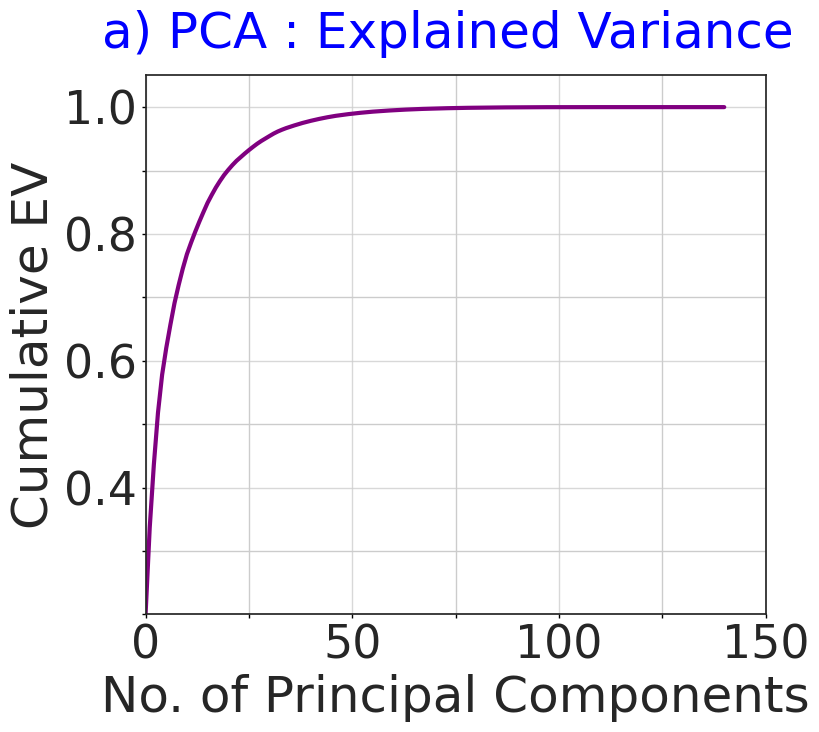

No. of components for PCA: 33
Explained variance for 96%  33 components:  [0.20062337 0.1360266  0.09961418 0.08188529 0.0597429  0.0422679
 0.03658428 0.03431791 0.02834419 0.02589469 0.02275784 0.0181531
 0.01706819 0.01604073 0.01515965 0.01463005 0.0123841  0.01168724
 0.01032211 0.00944983 0.00811485 0.00746072 0.00675899 0.00584221
 0.00566479 0.00540779 0.00512741 0.00489895 0.00439256 0.0039943
 0.00388084 0.00381632 0.00328879]
Cumulative: [0.20062337 0.33664997 0.43626415 0.51814944 0.57789234 0.62016025
 0.65674453 0.69106244 0.71940663 0.74530132 0.76805915 0.78621225
 0.80328044 0.81932116 0.83448081 0.84911086 0.86149496 0.87318221
 0.88350431 0.89295414 0.90106899 0.90852971 0.9152887  0.92113091
 0.9267957  0.9322035  0.9373309  0.94222986 0.94662242 0.95061672
 0.95449757 0.95831389 0.96160268]


In [9]:
# %run functions.ipynb
# scaler_cubic, std_train_cubic = std_data(X_train_cubic)
# input_name = list(X_train_cubic.columns.values)

# X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
# X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
# X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

# X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)

path='model_files//nn_model//cubic//'

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler_cubic = StandardScaler() # RENAME here 1 places
std_train = scaler_cubic.fit_transform(X_train_cubic) # RENAME here 1 places

# std_train_cubic = pd.DataFrame(data= std_train_cubic, columns=input_name)

import pickle
pickle.dump(scaler_cubic, open(path+'scaler_reg.pkl','wb')) # RENAME here 2 places

std_test = scaler_cubic.transform(X_test_cubic) # RENAME here 1 places


%run functions.ipynb

pca_cubic, X_train_pca_cubic = pca_fs(std_train,"plots\\", title="a) PCA") # RENAME here 1 places

from sklearn.preprocessing import MinMaxScaler

import pickle
pickle.dump(pca_cubic, open(path+'pca_reg.pkl','wb')) # RENAME here 2 places

X_test_pca_cubic =  pca_cubic.transform(std_test)      # RENAME here 1 places


y_train = y_train_cubic
X_train = X_train_pca_cubic

y_test = y_test_cubic
X_test = X_test_pca_cubic

num_features = X_train.shape[1]

y_train = np.array(list(y_train))
y_test = np.array(list(y_test))


In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the individual neural network models
def create_model_1():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(24, activation='LeakyReLU'))
    model.add(tf.keras.layers.Dense(14, activation='PReLU'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='selu'))

    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_2(learning_rate=0.001, l2_regularization=0.1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,),
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(48, activation='PReLU',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(30, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(18, activation='selu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(8, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dense(1))
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='msle', metrics=['mae', 'RootMeanSquaredError'])
    return model



def create_model_3(learning_rate=0.008, dropout_rate=0.1, l2_regularization=0.02):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,),
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(32, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(16, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='msle', metrics=['mae', 'RootMeanSquaredError'])
    return model


# Define the RNN model
def create_RNN():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(num_features, 1)),
        tf.keras.layers.SimpleRNN(units=32, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])   
    return model

# Define the CNN model
def create_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=24, activation='relu'),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])   
    return model

# Create instances of the individual models
model_2 = create_model_2(learning_rate=0.0008, l2_regularization=0.04)
model_3 = create_model_3(learning_rate=0.002, dropout_rate=0.05, l2_regularization=0.02)

# Train the individual models and store the training history
history_2 = model_2.fit(X_train, y_train, epochs=200, batch_size=10, verbose=2, validation_split=0.1)
history_3 = model_3.fit(X_train, y_train, epochs=200, batch_size=10, verbose=2, validation_split=0.1)





# Make predictions using the individual models
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)

# Combine the predictions
y_pred_ensemble = (y_pred_2 + y_pred_3) / 2

# Calculate the root mean squared error (RMSE) for the ensemble prediction
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
print("Root Mean Squared Error (Ensemble):", rmse_ensemble)

# model_1.save('model_files/nn_model/cubic/model_1.h5')
model_2.save('model_files/nn_model/cubic/model_2.h5')
model_3.save('model_files/nn_model/cubic/model_3.h5')
# model_4.save('model_files/nn_model/cubic/model_4.h5')
# model_5.save('model_files/nn_model/cubic/model_5.h5')

Epoch 1/200
30/30 - 1s - loss: 5.7170 - mae: 0.5981 - root_mean_squared_error: 0.7505 - val_loss: 5.1728 - val_mae: 1.0593 - val_root_mean_squared_error: 1.8583 - 532ms/epoch - 18ms/step
Epoch 2/200
30/30 - 0s - loss: 4.2623 - mae: 0.4867 - root_mean_squared_error: 0.6305 - val_loss: 3.9351 - val_mae: 0.9083 - val_root_mean_squared_error: 1.7757 - 103ms/epoch - 3ms/step
Epoch 3/200
30/30 - 0s - loss: 3.1470 - mae: 0.3874 - root_mean_squared_error: 0.5409 - val_loss: 2.9431 - val_mae: 0.7268 - val_root_mean_squared_error: 1.6719 - 159ms/epoch - 5ms/step
Epoch 4/200
30/30 - 0s - loss: 2.2749 - mae: 0.3298 - root_mean_squared_error: 0.5080 - val_loss: 2.1496 - val_mae: 0.6807 - val_root_mean_squared_error: 1.6296 - 149ms/epoch - 5ms/step
Epoch 5/200
30/30 - 0s - loss: 1.5987 - mae: 0.3331 - root_mean_squared_error: 0.5045 - val_loss: 1.5558 - val_mae: 0.6852 - val_root_mean_squared_error: 1.6249 - 123ms/epoch - 4ms/step
Epoch 6/200
30/30 - 0s - loss: 1.0800 - mae: 0.3314 - root_mean_squar

Epoch 45/200
30/30 - 0s - loss: 0.0429 - mae: 0.3390 - root_mean_squared_error: 0.5077 - val_loss: 0.2956 - val_mae: 0.6929 - val_root_mean_squared_error: 1.6248 - 115ms/epoch - 4ms/step
Epoch 46/200
30/30 - 0s - loss: 0.0429 - mae: 0.3370 - root_mean_squared_error: 0.5060 - val_loss: 0.2948 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6241 - 117ms/epoch - 4ms/step
Epoch 47/200
30/30 - 0s - loss: 0.0428 - mae: 0.3372 - root_mean_squared_error: 0.5063 - val_loss: 0.2936 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6230 - 101ms/epoch - 3ms/step
Epoch 48/200
30/30 - 0s - loss: 0.0428 - mae: 0.3398 - root_mean_squared_error: 0.5081 - val_loss: 0.2952 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6244 - 105ms/epoch - 4ms/step
Epoch 49/200
30/30 - 0s - loss: 0.0429 - mae: 0.3383 - root_mean_squared_error: 0.5070 - val_loss: 0.2951 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6243 - 110ms/epoch - 4ms/step
Epoch 50/200
30/30 - 0s - loss: 0.0428 - mae: 0.3398 - root_mean_

Epoch 89/200
30/30 - 0s - loss: 0.0429 - mae: 0.3377 - root_mean_squared_error: 0.5066 - val_loss: 0.2950 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6242 - 101ms/epoch - 3ms/step
Epoch 90/200
30/30 - 0s - loss: 0.0428 - mae: 0.3371 - root_mean_squared_error: 0.5062 - val_loss: 0.2936 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6230 - 122ms/epoch - 4ms/step
Epoch 91/200
30/30 - 0s - loss: 0.0429 - mae: 0.3377 - root_mean_squared_error: 0.5065 - val_loss: 0.2936 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6230 - 127ms/epoch - 4ms/step
Epoch 92/200
30/30 - 0s - loss: 0.0429 - mae: 0.3379 - root_mean_squared_error: 0.5066 - val_loss: 0.2934 - val_mae: 0.6936 - val_root_mean_squared_error: 1.6229 - 125ms/epoch - 4ms/step
Epoch 93/200
30/30 - 0s - loss: 0.0429 - mae: 0.3391 - root_mean_squared_error: 0.5073 - val_loss: 0.2937 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6231 - 134ms/epoch - 4ms/step
Epoch 94/200
30/30 - 0s - loss: 0.0429 - mae: 0.3391 - root_mean_

Epoch 133/200
30/30 - 0s - loss: 0.0429 - mae: 0.3388 - root_mean_squared_error: 0.5074 - val_loss: 0.2949 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6242 - 101ms/epoch - 3ms/step
Epoch 134/200
30/30 - 0s - loss: 0.0429 - mae: 0.3374 - root_mean_squared_error: 0.5063 - val_loss: 0.2941 - val_mae: 0.6934 - val_root_mean_squared_error: 1.6235 - 100ms/epoch - 3ms/step
Epoch 135/200
30/30 - 0s - loss: 0.0428 - mae: 0.3388 - root_mean_squared_error: 0.5078 - val_loss: 0.2958 - val_mae: 0.6929 - val_root_mean_squared_error: 1.6250 - 91ms/epoch - 3ms/step
Epoch 136/200
30/30 - 0s - loss: 0.0429 - mae: 0.3377 - root_mean_squared_error: 0.5065 - val_loss: 0.2959 - val_mae: 0.6929 - val_root_mean_squared_error: 1.6250 - 91ms/epoch - 3ms/step
Epoch 137/200
30/30 - 0s - loss: 0.0428 - mae: 0.3386 - root_mean_squared_error: 0.5072 - val_loss: 0.2977 - val_mae: 0.6923 - val_root_mean_squared_error: 1.6266 - 94ms/epoch - 3ms/step
Epoch 138/200
30/30 - 0s - loss: 0.0429 - mae: 0.3349 - root_me

Epoch 177/200
30/30 - 0s - loss: 0.0429 - mae: 0.3382 - root_mean_squared_error: 0.5069 - val_loss: 0.2937 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6231 - 98ms/epoch - 3ms/step
Epoch 178/200
30/30 - 0s - loss: 0.0428 - mae: 0.3391 - root_mean_squared_error: 0.5076 - val_loss: 0.2942 - val_mae: 0.6934 - val_root_mean_squared_error: 1.6235 - 98ms/epoch - 3ms/step
Epoch 179/200
30/30 - 0s - loss: 0.0429 - mae: 0.3388 - root_mean_squared_error: 0.5072 - val_loss: 0.2946 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6239 - 97ms/epoch - 3ms/step
Epoch 180/200
30/30 - 0s - loss: 0.0428 - mae: 0.3377 - root_mean_squared_error: 0.5065 - val_loss: 0.2937 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6231 - 95ms/epoch - 3ms/step
Epoch 181/200
30/30 - 0s - loss: 0.0429 - mae: 0.3388 - root_mean_squared_error: 0.5076 - val_loss: 0.2944 - val_mae: 0.6933 - val_root_mean_squared_error: 1.6237 - 96ms/epoch - 3ms/step
Epoch 182/200
30/30 - 0s - loss: 0.0429 - mae: 0.3373 - root_mean

Epoch 21/200
30/30 - 0s - loss: 0.0429 - mae: 0.3376 - root_mean_squared_error: 0.5064 - val_loss: 0.2939 - val_mae: 0.6934 - val_root_mean_squared_error: 1.6233 - 87ms/epoch - 3ms/step
Epoch 22/200
30/30 - 0s - loss: 0.0428 - mae: 0.3383 - root_mean_squared_error: 0.5071 - val_loss: 0.2948 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6241 - 91ms/epoch - 3ms/step
Epoch 23/200
30/30 - 0s - loss: 0.0427 - mae: 0.3377 - root_mean_squared_error: 0.5067 - val_loss: 0.2948 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6241 - 76ms/epoch - 3ms/step
Epoch 24/200
30/30 - 0s - loss: 0.0427 - mae: 0.3388 - root_mean_squared_error: 0.5071 - val_loss: 0.2947 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6240 - 80ms/epoch - 3ms/step
Epoch 25/200
30/30 - 0s - loss: 0.0429 - mae: 0.3407 - root_mean_squared_error: 0.5080 - val_loss: 0.2918 - val_mae: 0.6944 - val_root_mean_squared_error: 1.6215 - 85ms/epoch - 3ms/step
Epoch 26/200
30/30 - 0s - loss: 0.0434 - mae: 0.3400 - root_mean_squar

Epoch 65/200
30/30 - 0s - loss: 0.0428 - mae: 0.3374 - root_mean_squared_error: 0.5065 - val_loss: 0.2947 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6240 - 110ms/epoch - 4ms/step
Epoch 66/200
30/30 - 0s - loss: 0.0430 - mae: 0.3425 - root_mean_squared_error: 0.5099 - val_loss: 0.2935 - val_mae: 0.6936 - val_root_mean_squared_error: 1.6229 - 99ms/epoch - 3ms/step
Epoch 67/200
30/30 - 0s - loss: 0.0430 - mae: 0.3373 - root_mean_squared_error: 0.5065 - val_loss: 0.2984 - val_mae: 0.6921 - val_root_mean_squared_error: 1.6271 - 102ms/epoch - 3ms/step
Epoch 68/200
30/30 - 0s - loss: 0.0429 - mae: 0.3379 - root_mean_squared_error: 0.5065 - val_loss: 0.2941 - val_mae: 0.6934 - val_root_mean_squared_error: 1.6235 - 91ms/epoch - 3ms/step
Epoch 69/200
30/30 - 0s - loss: 0.0432 - mae: 0.3378 - root_mean_squared_error: 0.5067 - val_loss: 0.2945 - val_mae: 0.6933 - val_root_mean_squared_error: 1.6238 - 101ms/epoch - 3ms/step
Epoch 70/200
30/30 - 0s - loss: 0.0429 - mae: 0.3390 - root_mean_sq

Epoch 109/200
30/30 - 0s - loss: 0.0428 - mae: 0.3368 - root_mean_squared_error: 0.5058 - val_loss: 0.2937 - val_mae: 0.6935 - val_root_mean_squared_error: 1.6231 - 87ms/epoch - 3ms/step
Epoch 110/200
30/30 - 0s - loss: 0.0431 - mae: 0.3408 - root_mean_squared_error: 0.5089 - val_loss: 0.2924 - val_mae: 0.6941 - val_root_mean_squared_error: 1.6219 - 90ms/epoch - 3ms/step
Epoch 111/200
30/30 - 0s - loss: 0.0428 - mae: 0.3386 - root_mean_squared_error: 0.5072 - val_loss: 0.2951 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6243 - 88ms/epoch - 3ms/step
Epoch 112/200
30/30 - 0s - loss: 0.0428 - mae: 0.3376 - root_mean_squared_error: 0.5067 - val_loss: 0.2943 - val_mae: 0.6933 - val_root_mean_squared_error: 1.6237 - 82ms/epoch - 3ms/step
Epoch 113/200
30/30 - 0s - loss: 0.0427 - mae: 0.3385 - root_mean_squared_error: 0.5069 - val_loss: 0.2944 - val_mae: 0.6933 - val_root_mean_squared_error: 1.6238 - 87ms/epoch - 3ms/step
Epoch 114/200
30/30 - 0s - loss: 0.0428 - mae: 0.3389 - root_mean

Epoch 153/200
30/30 - 0s - loss: 0.0428 - mae: 0.3374 - root_mean_squared_error: 0.5064 - val_loss: 0.2947 - val_mae: 0.6932 - val_root_mean_squared_error: 1.6240 - 124ms/epoch - 4ms/step
Epoch 154/200
30/30 - 0s - loss: 0.0429 - mae: 0.3405 - root_mean_squared_error: 0.5083 - val_loss: 0.2940 - val_mae: 0.6934 - val_root_mean_squared_error: 1.6234 - 118ms/epoch - 4ms/step
Epoch 155/200
30/30 - 0s - loss: 0.0428 - mae: 0.3374 - root_mean_squared_error: 0.5066 - val_loss: 0.2944 - val_mae: 0.6933 - val_root_mean_squared_error: 1.6238 - 108ms/epoch - 4ms/step
Epoch 156/200
30/30 - 0s - loss: 0.0428 - mae: 0.3396 - root_mean_squared_error: 0.5078 - val_loss: 0.2927 - val_mae: 0.6940 - val_root_mean_squared_error: 1.6222 - 92ms/epoch - 3ms/step
Epoch 157/200
30/30 - 0s - loss: 0.0429 - mae: 0.3383 - root_mean_squared_error: 0.5071 - val_loss: 0.2950 - val_mae: 0.6931 - val_root_mean_squared_error: 1.6243 - 83ms/epoch - 3ms/step
Epoch 158/200
30/30 - 0s - loss: 0.0428 - mae: 0.3398 - root_m

Epoch 197/200
30/30 - 0s - loss: 0.0429 - mae: 0.3363 - root_mean_squared_error: 0.5056 - val_loss: 0.2958 - val_mae: 0.6929 - val_root_mean_squared_error: 1.6249 - 106ms/epoch - 4ms/step
Epoch 198/200
30/30 - 0s - loss: 0.0429 - mae: 0.3369 - root_mean_squared_error: 0.5061 - val_loss: 0.2960 - val_mae: 0.6928 - val_root_mean_squared_error: 1.6251 - 93ms/epoch - 3ms/step
Epoch 199/200
30/30 - 0s - loss: 0.0430 - mae: 0.3411 - root_mean_squared_error: 0.5091 - val_loss: 0.2930 - val_mae: 0.6938 - val_root_mean_squared_error: 1.6225 - 88ms/epoch - 3ms/step
Epoch 200/200
30/30 - 0s - loss: 0.0429 - mae: 0.3381 - root_mean_squared_error: 0.5071 - val_loss: 0.2955 - val_mae: 0.6930 - val_root_mean_squared_error: 1.6247 - 91ms/epoch - 3ms/step
2/2 [==============================] - 0s 2ms/step
Root Mean Squared Error (Ensemble): 0.42531473179485246


In [21]:
# Plot the learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(6, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

   
    plt.tight_layout()
    plt.show()

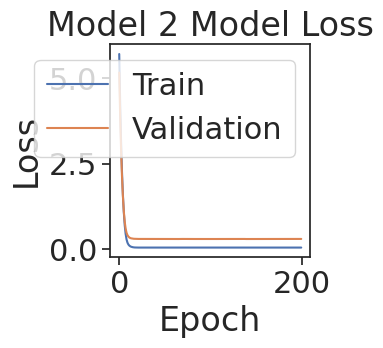

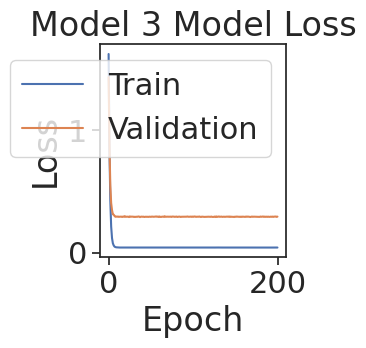

In [22]:
# Plot learning curves for model_2 and model_3
plot_learning_curve(history_2, "Model 2")
plot_learning_curve(history_3, "Model 3")

In [23]:
tf.keras.Input(shape=(num_features,))

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'input_3')>

In [24]:
from sklearn.metrics import r2_score
r2_mean = r2_score(y_pred_ensemble,y_test_cubic)
print(r2_mean)

-203666985224433.84


In [ ]:
modela2 = model_2.fit(X_train, y_train, epochs=200, batch_size=10, verbose=2, validation_split=0.1)
modela3 = model_3.fit(X_train, y_train, epochs=200, batch_size=10, verbose=2, validation_split=0.1)

In [ ]:
# Plot the learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(6, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the learning curves using the training history
# plot_learning_curves(history_pca_1)

In [ ]:
plot_learning_curves(modela2)

In [ ]:
plot_learning_curves(modela3)

## 1.2  CAT A: tetra42m

In [ ]:
# %run functions.ipynb
# scaler_cubic, std_train_cubic = std_data(X_train_cubic)
# input_name = list(X_train_cubic.columns.values)

# X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
# X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
# X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

# X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)

path='model_files//nn_model//tetra42m//'

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler_tetra42m = StandardScaler() # RENAME here 1 places
std_train = scaler_tetra42m.fit_transform(X_train_tetra42m) # RENAME here 1 places

# std_train_cubic = pd.DataFrame(data= std_train_cubic, columns=input_name)

import pickle
pickle.dump(scaler_tetra42m, open(path+'scaler_reg.pkl','wb')) # RENAME here 2 places

std_test = scaler_tetra42m.transform(X_test_tetra42m) # RENAME here 1 places


%run functions.ipynb

pca_tetra42m, X_train_pca_tetra42m = pca_fs(std_train,"plots\\", title="a) PCA") # RENAME here 1 places


from sklearn.preprocessing import MinMaxScaler

import pickle
pickle.dump(pca_tetra42m, open(path+'pca_reg.pkl','wb')) # RENAME here 2 places


X_test_pca_tetra42m =  pca_tetra42m.transform(std_test)      # RENAME here 1 places

y_train = y_train_tetra42m
X_train = X_train_pca_tetra42m

y_test = y_test_tetra42m
X_test = X_test_pca_tetra42m

num_features = X_train.shape[1]

y_train = np.array(list(y_train))
y_test = np.array(list(y_test))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the individual neural network models
def create_model_1():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(24, activation='LeakyReLU'))
    model.add(tf.keras.layers.Dense(14, activation='PReLU'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='selu'))

    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_3():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

# Define the RNN model
def create_RNN():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(num_features, 1)),
        tf.keras.layers.SimpleRNN(units=32, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])   
    return model

# Define the CNN model
def create_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=24, activation='relu'),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])    
    return model

# Create instances of the individual models
model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()
model_4 = create_RNN()
model_5 = create_CNN()


# Train the individual models
model_1.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_2.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_3.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_4.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_5.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)


# Make predictions using the individual models
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)


# Combine the predictions
y_pred_ensemble = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5

# Calculate the root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

model_1.save('model_files/nn_model/tetra42m/model_1.h5')
model_2.save('model_files/nn_model/tetra42m/model_2.h5')
model_3.save('model_files/nn_model/tetra42m/model_3.h5')
model_4.save('model_files/nn_model/tetra42m/model_4.h5')
model_5.save('model_files/nn_model/tetra42m/model_5.h5')


In [ ]:
y_pred_ensemble

In [ ]:
from sklearn.metrics import r2_score
r2_mean = r2_score(y_pred_ensemble,y_test)
print(r2_mean)

## 1.3   CAT A: ortho222

In [ ]:
# %run functions.ipynb
# scaler_cubic, std_train_cubic = std_data(X_train_cubic)
# input_name = list(X_train_cubic.columns.values)

# X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
# X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
# X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

# X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)
path='model_files//nn_model//ortho222//'

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler_ortho222 = StandardScaler() # RENAME here 1 places
std_train = scaler_ortho222.fit_transform(X_train_ortho222) # RENAME here 1 places

# std_train_cubic = pd.DataFrame(data= std_train_cubic, columns=input_name)

import pickle
pickle.dump(scaler_ortho222, open(path+'scaler_reg.pkl','wb')) # RENAME here 2 places

std_test = scaler_ortho222.transform(X_test_ortho222) # RENAME here 1 places


%run functions.ipynb

pca_ortho222, X_train_pca_ortho222 = pca_fs(std_train,"plots\\", title="a) PCA") # RENAME here 1 places


from sklearn.preprocessing import MinMaxScaler

import pickle
pickle.dump(pca_ortho222, open(path+'pca_reg.pkl','wb')) # RENAME here 2 places


X_test_pca_ortho222 =  pca_ortho222.transform(std_test)      # RENAME here 1 places

y_train = y_train_ortho222
X_train = X_train_pca_ortho222

y_test = y_test_ortho222
X_test = X_test_pca_ortho222

num_features = X_train.shape[1]

y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the individual neural network models
def create_model_1():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(24, activation='LeakyReLU'))
    model.add(tf.keras.layers.Dense(14, activation='PReLU'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='selu'))

    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_3():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

# Define the RNN model
def create_RNN():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(num_features, 1)),
        tf.keras.layers.SimpleRNN(units=32, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])   
    return model

# Define the CNN model
def create_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=24, activation='relu'),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])    
    return model

# Create instances of the individual models
model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()
model_4 = create_RNN()
model_5 = create_CNN()


# Train the individual models
model_1.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_2.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_3.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_4.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_5.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)


# Make predictions using the individual models
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)


# Combine the predictions
y_pred_ensemble = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5

# Calculate the root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

model_1.save('model_files/nn_model/ortho222/model_1.h5')
model_2.save('model_files/nn_model/ortho222/model_2.h5')
model_3.save('model_files/nn_model/ortho222/model_3.h5')
model_4.save('model_files/nn_model/ortho222/model_4.h5')
model_5.save('model_files/nn_model/ortho222/model_5.h5')


In [ ]:
from sklearn.metrics import r2_score
r2_mean = r2_score(y_pred_ensemble,y_test)
print(r2_mean)

## 2.1   CAT B: orthomm2

In [ ]:
# %run functions.ipynb
# scaler_cubic, std_train_cubic = std_data(X_train_cubic)
# input_name = list(X_train_cubic.columns.values)

# X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
# X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
# X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

# X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)

path='model_files//nn_model//orthomm2//'

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler_orthomm2 = StandardScaler() # RENAME here 1 places
std_train = scaler_orthomm2.fit_transform(X_train_orthomm2) # RENAME here 1 places

# std_train_cubic = pd.DataFrame(data= std_train_cubic, columns=input_name)

import pickle
pickle.dump(scaler_orthomm2, open(path+'scaler_reg.pkl','wb')) # RENAME here 2 places

std_test = scaler_orthomm2.transform(X_test_orthomm2) # RENAME here 1 places


%run functions.ipynb


pca_orthomm2, X_train_pca_orthomm2 = pca_fs(std_train,"plots\\", title="a) PCA") # RENAME here 1 places


from sklearn.preprocessing import MinMaxScaler

import pickle
pickle.dump(pca_orthomm2, open(path+'pca_reg.pkl','wb')) # RENAME here 2 places


X_test_pca_orthomm2 =  pca_orthomm2.transform(std_test)      # RENAME here 1 places


y_train = y_train_orthomm2
X_train = X_train_pca_orthomm2

y_test = y_test_orthomm2
X_test = X_test_pca_orthomm2

num_features = X_train.shape[1]

y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the individual neural network models
def create_model_1():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(24, activation='LeakyReLU'))
    model.add(tf.keras.layers.Dense(14, activation='PReLU'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='selu'))

    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_3():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

# Define the RNN model
def create_RNN():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(num_features, 1)),
        tf.keras.layers.SimpleRNN(units=32, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])    
    return model



# Define the CNN model
def create_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=24, activation='relu'),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])    
    return model


# Create instances of the individual models
model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()
model_4 = create_RNN()
model_5 = create_CNN()


# Train the individual models
model_1.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_2.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_3.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_4.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)
model_5.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2, validation_split=0.1)


# Make predictions using the individual models
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
y_pred_4 = model_4.predict(X_test)
y_pred_5 = model_5.predict(X_test)


# Combine the predictions
y_pred_ensemble = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5

# Calculate the root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

model_1.save('model_files/nn_model/orthomm2/model_1.h5')
model_2.save('model_files/nn_model/orthomm2/model_2.h5')
model_3.save('model_files/nn_model/orthomm2/model_3.h5')
model_4.save('model_files/nn_model/orthomm2/model_4.h5')
model_5.save('model_files/nn_model/orthomm2/model_5.h5')



In [ ]:
from sklearn.metrics import r2_score
r2_mean = r2_score(y_pred_ensemble,y_test)
print(r2_mean)

## 2.2   CAT B: hextetramm

In [ ]:
# %run functions.ipynb
# scaler_cubic, std_train_cubic = std_data(X_train_cubic)
# input_name = list(X_train_cubic.columns.values)

# X_train_cubic, X_test_cubic, y_train_cubic, y_test_cubic = tensor_preprocessing(df_cubic)
# X_train_tetra42m, X_test_tetra42m, y_train_tetra42m, y_test_tetra42m  = tensor_preprocessing(df_tetra42m)
# X_train_ortho222, X_test_ortho222, y_train_ortho222, y_test_ortho222  = tensor_preprocessing(df_ortho222)

# X_train_orthomm2, X_test_orthomm2, y_train_orthomm2, y_test_orthomm2  = tensor_preprocessing(df_orthomm2)
# X_train_hextetramm, X_test_hextetramm, y_train_hextetramm, y_test_hextetramm = tensor_preprocessing(df_hextetramm)

path='model_files//nn_model//hextetramm//'

from sklearn.preprocessing import StandardScaler
# Standardize the data
scaler_hextetramm = StandardScaler() # RENAME here 1 places
std_train = scaler_hextetramm.fit_transform(X_train_hextetramm) # RENAME here 1 places

# std_train_cubic = pd.DataFrame(data= std_train_cubic, columns=input_name)

import pickle
pickle.dump(scaler_hextetramm, open(path+'scaler_reg.pkl','wb')) # RENAME here 2 places

std_test = scaler_hextetramm.transform(X_test_hextetramm) # RENAME here 1 places


%run functions.ipynb


pca_hextetramm, X_train_pca_hextetramm = pca_fs(std_train,"plots\\", title="a) PCA") # RENAME here 1 places


from sklearn.preprocessing import MinMaxScaler

import pickle
pickle.dump(pca_hextetramm, open(path+'pca_reg.pkl','wb')) # RENAME here 2 places

X_test_pca_hextetramm =  pca_hextetramm.transform(std_test)      # RENAME here 1 places


y_train = y_train_hextetramm
X_train = X_train_pca_hextetramm

y_test = y_test_hextetramm
X_test = X_test_pca_hextetramm

num_features = X_train.shape[1]

y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

###### X_train[3]

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop

num_features = X_train.shape[1]

import numpy as np
import tensorflow as tf

np.random.seed(33)
tf.random.set_seed(33)



# Define the individual neural network models
def create_model_1():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(28, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(20, activation='LeakyReLU'))
    tf.keras.layers.Dropout(0.1),

    model.add(tf.keras.layers.Dense(12, activation='PReLU'))
    tf.keras.layers.Dropout(0.1),

#     model.add(tf.keras.layers.Dense(8, activation='relu'))
#     tf.keras.layers.Dropout(0.1),

    model.add(tf.keras.layers.Dense(4, activation='relu'))

    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(28, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(18, activation='LeakyReLU'))
    tf.keras.layers.Dropout(0.1),

    model.add(tf.keras.layers.Dense(12, activation='selu'))
#     tf.keras.layers.Dropout(0.1),

    model.add(tf.keras.layers.Dense(8, activation='PReLU'))
    model.add(tf.keras.layers.Dense(6, activation='relu'))
    tf.keras.layers.Dropout(0.1),

    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer=Adam(learning_rate=0.0015), loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

def create_model_3():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(30, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    tf.keras.layers.Dropout(0.1),
    model.add(tf.keras.layers.Dense(12, activation='selu'))
    tf.keras.layers.Dropout(0.1),
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    model.compile(optimizer=Adam(learning_rate=0.002), loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

# Define the RNN model
def create_RNN():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(num_features, 1)),
        tf.keras.layers.SimpleRNN(units=32, activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError']) 
    return model


# Define the CNN model
def create_CNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=24, activation='relu'),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(units=16, activation='selu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='relu'),
        tf.keras.layers.Dense(units=y_train.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    
    return model


# Create instances of the individual models
model_1 = create_model_1()
model_2 = create_model_2()
model_3 = create_model_3()
model_4 = create_RNN()
model_5 = create_CNN()


# Train the individual models
model_1.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_split=0.1, shuffle=False)
# model_2.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_split=0.1, shuffle=False)
# model_3.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_split=0.1, shuffle=False)
# model_4.fit(X_train, y_train, epochs=100, batch_size=8, verbose=2, validation_split=0.1)
# model_5.fit(X_train, y_train, epochs=100, batch_size=8, verbose=2, validation_split=0.1)


# Make predictions using the individual models
y_pred_1 = model_1.predict(X_test)
# y_pred_2 = model_2.predict(X_test)
# y_pred_3 = model_3.predict(X_test)
# y_pred_4 = model_4.predict(X_test)
# y_pred_5 = model_5.predict(X_test)



# Combine the predictions
# y_pred_ensemble = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5) / 5
y_pred_ensemble = (y_pred_1 + y_pred_2 + y_pred_3) / 3

# Calculate the root mean squared error (RMSE)
mse = mean_squared_error(y_test, y_pred_ensemble)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

model_1.save('model_files/nn_model/hextetramm/model_1.h5')
# model_2.save('model_files/nn_model/hextetramm/model_2.h5')
# model_3.save('model_files/nn_model/hextetramm/model_3.h5')
# model_4.save('model_files/nn_model/hextetramm/model_4.h5')
# model_5.save('model_files/nn_model/hextetramm/model_5.h5')



In [ ]:
from sklearn.metrics import r2_score
r2_mean = r2_score(y_pred_ensemble,y_test)
print(r2_mean)

In [ ]:
r2_mean = r2_score(y_pred_1,y_test)

In [ ]:
r2_mean

In [ ]:
r2_score(y_pred_2,y_test)

In [ ]:
r2_score(y_pred_3,y_test)

In [ ]:
# Final hyperparameter-tuning


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner import Objective
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_1', min_value=16, max_value=64, step=4),
                           activation=hp.Choice('activation_1', values=['relu', 'LeakyReLU', 'selu']),
                           input_shape=(num_features,)))
    model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(units=hp.Int('units_2', min_value=12, max_value=32, step=4),
                           activation=hp.Choice('activation_2', values=['relu', 'PReLU'])))
    model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(units=hp.Int('units_3', min_value=8, max_value=24, step=4),
                           activation=hp.Choice('activation_3', values=['relu', 'PReLU'])))
    model.add(layers.Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(units=hp.Int('units_4', min_value=2, max_value=12, step=2),
                           activation=hp.Choice('activation_4', values=['relu'])))
    
    model.add(layers.Dense(y_train.shape[1]))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective=Objective("val_root_mean_squared_error", direction="min"),
    max_trials=20,
    executions_per_trial=5,
    directory='hyperparameter_tuning',
    project_name='your_model_name')

# Create a ModelCheckpoint callback to save the best models
checkpoint_callback = ModelCheckpoint(
    filepath='best_models/model_{epoch:02d}-{val_root_mean_squared_error:.2f}.h5',
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[checkpoint_callback])

# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=3)[0]
best_model.summary()


In [ ]:
best_model.predict(X_test)

In [ ]:
r2_score(best_model.predict(X_test),y_test)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop

# Define the neural network model
def create_model(optimizer='adam', activation='relu', learning_rate=0.001, batch_size=32):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation=activation, input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(24, activation=activation))
    model.add(tf.keras.layers.Dense(14, activation=activation))
    model.add(tf.keras.layers.Dense(8, activation=activation))
    model.add(tf.keras.layers.Dense(4, activation=activation))
    model.add(tf.keras.layers.Dense(y_train.shape[1]))
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'RootMeanSquaredError'])
    return model

# Prepare your data
# X_train and y_train are your training data

# Set the number of features
num_features = X_train.shape[1]

# Wrap the Keras model into a scikit-learn compatible regressor
regressor = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'LeakyReLU', 'PReLU', 'selu'],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'batch_size': [16, 32, 64]
}

# Define the scoring metric
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

# Perform grid search
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=scoring, refit='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)

# Print the best hyperparameters and scores
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Negative Mean Squared Error: ", grid_result.best_score_)
print("Best Negative Mean Absolute Error: ", grid_result.cv_results_['mean_test_neg_mean_absolute_error'][grid_result.best_index_])
print("Best Negative Root Mean Squared Error: ", grid_result.cv_results_['mean_test_neg_root_mean_squared_error'][grid_result.best_index_])



In [ ]:
model_1 = create_model(optimizer='adam', activation='relu', learning_rate=0.01, batch_size=32)

model_1.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_split=0.1)


In [ ]:
model_1.evaluate(X_test)

In [ ]:
X_test

In [ ]:
y_pred_1 = model_1.predict(X_test)


In [ ]:
y_pred_1

In [ ]:
y_test

In [ ]:
y_train

In [ ]:
stop here

# Pre-Processing for Transfer Learning

In [ ]:
%run functions.ipynb
X_fs = X_pca_1
scaler_with_targets, df_train_transfer = std_data(X_fs)

In [ ]:
X_pca.describe()

In [ ]:
X_pca

In [ ]:
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [ ]:
y_train

In [ ]:
import ast

# convert string to nested list
data_list = ast.literal_eval(y_train)

# convert list to numpy array
data_array = np.array(data_list, dtype=float)


In [ ]:
np.random.rand(2520, 3, 6)

In [ ]:
np.random.rand(2520, 30)

In [ ]:
#X_pca = np.array(list(X_pca))

In [ ]:
X_pca

In [ ]:
import tensorflow as tf
import numpy as np

# Generate random data
# x_train = np.random.rand(100, 30)
# y_train = np.random.rand(100, 3, 6)

x_train = X_pca
#y_train = np.random.rand(100, 3, 6)  

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((40, 1), input_shape=(40,)),
    tf.keras.layers.SimpleRNN(units=64, activation='tanh'),
    tf.keras.layers.RepeatVector(3),
    tf.keras.layers.SimpleRNN(units=64, activation='tanh', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=6, activation='linear'))
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Generate random test input
x_test = test_pca_1  #np.random.rand(10, 40)

# Get model prediction
y_pred = model.predict(x_test)

# Print prediction shape and values
print("Prediction shape:", y_pred.shape)
print("Prediction values:\n", y_pred[0])



In [ ]:
y_test[0]

In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = y_pred #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)

In [ ]:
import tensorly as tl
import numpy as np
from tensorly import unfold
y_train = unfold(np.array(list(y_train)), 0) # mode-1 unfolding
y_test = unfold(np.array(list(y_test)), 0) # mode-1 unfolding

unfolded = y_train

In [ ]:
import tensorflow as tf
import numpy as np

# Generate random data
# x_train = np.random.rand(100, 30)
# y_train = np.random.rand(100, 3, 6)

x_train = X_pca
#y_train = np.random.rand(100, 3, 6)  

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((40, 1), input_shape=(40,)),
    tf.keras.layers.SimpleRNN(units=64, activation='sigmoid'),
    tf.keras.layers.RepeatVector(3),
    tf.keras.layers.SimpleRNN(units=48, activation='relu'),
    tf.keras.layers.RepeatVector(30),
    tf.keras.layers.SimpleRNN(units=20, activation='tanh'),
    tf.keras.layers.RepeatVector(3),
    tf.keras.layers.SimpleRNN(units=64, activation='tanh', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=6, activation='sigmoid'))
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=2, validation_split=0.2)

# Generate random test input
x_test = test_pca_1  #np.random.rand(10, 40)

# Get model prediction
y_pred = model.predict(x_test)

# Print prediction shape and values
print("Prediction shape:", y_pred.shape)
print("Prediction values:\n", y_pred[0])



In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = y_pred #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)

In [ ]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=64, return_sequences=False, input_shape=(40, 1)),
    tf.keras.layers.RepeatVector(3),
    tf.keras.layers.GRU(units=64, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=6, activation='linear'))
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_pca, y_train, epochs=10, batch_size=32)

# Generate random test input
x_test = test_pca_1  #np.random.rand(10, 30, 1)

# Get model prediction
y_pred = model.predict(x_test)

# Print prediction shape and values
print("Prediction shape:", y_pred.shape)
print("Prediction values:\n", y_pred[0])


In [ ]:
y_pred[20]

In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = y_pred #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)

In [ ]:
# Without Transfer learning

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_pca #np.random.random((1000, 5))
y = y_train #y_train #np.random.random((1000, 6))  # 2x3 output array for each input

#X = np.random.random((1000, 5))
#y = np.random.random((1000, 6))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)
print(np.shape(X)[1])
print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=np.shape(X)[1]))
model.add(Dense(48, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(48, activation='relu'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(18, activation='sigmoid'))  # output layer with 18 nodes, corresponding to 3x6 array

# compile the model
model.compile(optimizer='Nadam', loss='mse', metrics=['mse','mae'])

# train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=2, validation_split=0.2)#, metrics=['mse','mae','accuracy'])

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
X_new = test_pca_1 #X_test_fs #np.random.random((5, 30))
#X_new = np.random.random((5, 5))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
#y_pred = y_pred.reshape(y_pred.shape[0], 3, 6)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
y_test[11]

In [ ]:
y_pred[11]

In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = y_pred #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)

## Data Augmentation for Transfer modeling

In [ ]:

from tensorflow.keras.utils import Sequence


aug_batch = 200
aug_train_shape = 40
aug_epochs = 50

class DataGenerator(Sequence):
    def __init__(self, x, y, batch_size=aug_batch, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, index):
        batch_x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            idx = np.arange(len(self.x))
            np.random.shuffle(idx)
            self.x = self.x[idx]
            self.y = self.y[idx]

# Generate some sample data
# x_train = np.random.rand(2520, 30)
# y_train = np.random.rand(2520, 3, 6)

x_train = X_pca#np.random.rand(2520, 30)
y_train = y_train #np.random.rand(2520, 3, 6)


# Define the data augmentation parameters
datagen = DataGenerator(
    x_train, y_train,
    batch_size=aug_batch,
    shuffle=True)

# Set the batch size and number of epochs


# Create a new array to hold the augmented data
aug_x_train = np.zeros((batch_size * aug_epochs, aug_train_shape))
aug_y_train = np.zeros((batch_size * aug_epochs, 3, 6))

# Generate augmented data
train_generator = DataGenerator(x_train, y_train, batch_size=aug_batch, shuffle=True)
aug_x_train, aug_y_train = train_generator.__getitem__(0)
for i in range(1, epochs):
    x_batch, y_batch = train_generator.__getitem__(i)
    aug_x_train = np.vstack((aug_x_train, x_batch))
    aug_y_train = np.vstack((aug_y_train, y_batch))

# Print the shape of the augmented data
print("Augmented data shapes:")
print(aug_x_train.shape)
print(aug_y_train.shape)

In [ ]:
# Using this to develop dataframe for transfer learning

In [ ]:
min_values =[]
max_values =[]

df_train_transfer = X_pca

num_rows = 10000
num_cols = len(X_pca.columns)

print(len(X_pca.columns))
for items in range(len(X_pca.columns)):
    #print(items, input_name[items])
    #print(df_train_transfer.iloc[:,[items]].min())
    low = df_train_transfer.iloc[:,[items]].min().values
    high = df_train_transfer.iloc[:,[items]].max().values
    
    low = low[0]
    high = high[0]
    #print(items)
    #print(low,high)
    min_values.append(low)
    max_values.append(high)
    
data = np.random.uniform(low=min_values, high=max_values, size=(num_rows, num_cols))

#df = pd.DataFrame(data, columns=column_name_transfer)
df = pd.DataFrame(data)
X_transfer = df


In [ ]:
X_transfer.describe()

## Bootstaping



In [ ]:
## To generate 10000 new datasets with the same relationships between elements within the 6 columns 
# of original 2520x6 numpy array, use a technique called bootstrapping.
# Bootstrapping involves randomly resampling the original data with replacement to create new datasets

In [ ]:
import numpy as np

# your original 2520x6 numpy array
original_data = y_train #np.random.rand(2520, 6)

# number of datasets to generate
num_datasets = 10000

# create empty array to store new datasets
new_datasets = np.empty((num_datasets, 18))

# loop through number of datasets
for i in range(num_datasets):
    # randomly resample the original data with replacement along the first axis
    resampled_data = np.random.choice(original_data.shape[0], size=original_data.shape[0], replace=True)
    # use the resampled indices to select rows from the original data along the first axis
    resampled_data = original_data[resampled_data]
    # calculate the means of each column of the resampled data
    means = np.mean(resampled_data, axis=0)
    # calculate the standard deviations of each column of the resampled data
    stds = np.std(resampled_data, axis=0)
    # normalize the resampled data using the means and standard deviations
    normalized_data = (resampled_data - means) / stds
    # calculate the means of each column of the normalized data
    new_means = np.mean(normalized_data, axis=0)
    # calculate the standard deviations of each column of the normalized data
    new_stds = np.std(normalized_data, axis=0)
    # denormalize the normalized data using the new means and standard deviations
    denormalized_data = (normalized_data * new_stds) + new_means
    # add denormalized data to new_datasets array
    new_datasets[i] = denormalized_data[0]
y_transfer = new_datasets

# Transfer Learning

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size':18})
#plt.rcParams.update({'font.size':22})
plt.rcParams["figure.figsize"]=(12, 10)
#The above is same as
# matplotlib.rcParams.update({'font.size':22})
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,LeakyReLU, PReLU
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.initializers import Constant
#from tensorflow.python.keras.layers import LeakyReLU

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn
scaler_mm=MinMaxScaler()
Xscaled=scaler_mm.fit_transform(X_transfer)
Yscaled=scaler_mm.fit_transform(y_transfer)

In [ ]:
#Dividing things into train and test
#X_train, X_test, y_train, y_test = train_test_split(Xscaled, Yscaled)

#Keras model configuration for NN API
model_p = Sequential()
#model.add(Dense(6, input_dim=5, kernel_initializer='normal', activation='relu'))
model_p.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
#model.add(Dense(3, activation='relu'))
#model.add(Dense(6, activation='LeakyReLU'))
#model.add(Dense(4, activation='tanh'))
#model.add(Dense(10, activation='LeakyReLU'))
#model.add(Dense(3, activation='tanh'))
#model.add(Dense(1, activation='linear'))
#model.add(Dense(8, activation='relu'))
model_p.add(Dense(24, activation='relu'))
model_p.add(Dense(20, activation='relu'))

model_p.add(Dense(2, activation='relu'))

model_p.add(Dense(6, activation='relu'))
model_p.add(Dense(12, activation='relu'))

model_p.add(Dense(18, activation='sigmoid'))
model_p.summary()

In [ ]:
#from keras.optimizers import Adam
# https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
# https://exerror.com/importerror-cannot-import-name-adam-from-keras-optimizers-error/
# https://stackoverflow.com/questions/50056356/could-not-interpret-optimizer-identifier-error-in-keras
# https://towardsdatascience.com/how-to-optimize-learning-rate-with-tensorflow-its-easier-than-you-think-164f980a7c7b
#Error MSE and MAE- compiling
#model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','accuracy'])
from tensorflow.python.keras.optimizers import adam_v2
learning_rate=2.0E-02 #2.50E-04 #0.0015
opt=adam_v2.Adam(learning_rate = learning_rate)
#opt=Adam(learning_rate = learning_rate)
#ValueError: Could not interpret optimizer identifier: <keras.optimizer_v2.adam.Adam object at 0x7fc9ec1a7d50>
#opt=tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
#opt=tf.optimizers.Adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0., amsgrad = False)
#Error MSE and MAE- compiling
model_p.compile(loss='mse', optimizer=opt, metrics=['mse','mae','mape','accuracy']) # no apostrophe ' ' for optimizers defined by user 
#Fitting 
#history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=200, batch_size=16,  verbose=1, validation_split=0.2)

history = model_p.fit(Xscaled, Yscaled, epochs=50, batch_size=20,  verbose=1)


In [ ]:
#Print and plot using matplotlib
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], color='k', marker='o')
#plt.plot(history.history['val_loss'],color='r', marker='s') #no validation
plt.title('model loss')
plt.ylabel('mse (knmps^2)') #plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.legend(['train data', 'validation data'], loc='upper right')
plt.show()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy']) #no validation
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train data', 'validation data'], loc='upper left')
plt.show()


In [ ]:
#####################saving the loss history###############################
#####################Prediction Pure Sn-40W###############################
#####Reference############################################################
##### https://stackoverflow.com/questions/38445982/how-to-log-keras-loss-output-to-a-file
#####
train_loss = history.history['loss']
#val_loss   = history.history['val_loss']
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
############################################################################
loss_history = np.array(train_loss)
np.savetxt("train_loss_pretrained.txt", loss_history, delimiter=",")
#val_loss_history = np.array(val_loss)
#np.savetxt("val_loss.txt", val_loss_history, delimiter=",")
############################################################################



# Transfering weight of psedo-train

In [ ]:
# Innovation in transfer learning
# Freeze the layers of the first model
for layer in model_p.layers:
    layer.trainable = False


In [ ]:
#Keras model configuration for NN API
model = Sequential()
#model.add(Dense(6, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
#model.add(Dense(3, activation='relu'))
#model.add(Dense(6, activation='LeakyReLU'))
#model.add(Dense(4, activation='tanh'))
#model.add(Dense(10, activation='LeakyReLU'))
#model.add(Dense(3, activation='tanh'))
#model.add(Dense(1, activation='linear'))
#model.add(Dense(8, activation='relu'))

model.add(Dense(24, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(2, activation='relu'))

model.add(Dense(6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(18, activation='sigmoid'))
model.summary()

In [ ]:
# Set the weights of the second model to be the same as the first model (pretrained model)
model.set_weights(model_p.get_weights())

In [ ]:
#from keras.optimizers import Adam
# https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
# https://exerror.com/importerror-cannot-import-name-adam-from-keras-optimizers-error/
# https://stackoverflow.com/questions/50056356/could-not-interpret-optimizer-identifier-error-in-keras
# https://towardsdatascience.com/how-to-optimize-learning-rate-with-tensorflow-its-easier-than-you-think-164f980a7c7b
#Error MSE and MAE- compiling
#model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','accuracy'])
from tensorflow.python.keras.optimizers import adam_v2
learning_rate=2.0E-02 #2.50E-04 #0.0015
opt=adam_v2.Adam(learning_rate = learning_rate)
#opt=Adam(learning_rate = learning_rate)
#ValueError: Could not interpret optimizer identifier: <keras.optimizer_v2.adam.Adam object at 0x7fc9ec1a7d50>
#opt=tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
#opt=tf.optimizers.Adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0., amsgrad = False)
#Error MSE and MAE- compiling
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae','accuracy']) # no apostrophe ' ' for optimizers defined by user 
#Fitting 
#history = model.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)
history = model.fit(X_fs, y_train, epochs=20, batch_size=16,  verbose=1, validation_split=0.2)


In [ ]:
#Print and plot using matplotlib
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], color='k', marker='o')
plt.plot(history.history['val_loss'],color='r', marker='s')
plt.title('model loss')
plt.ylabel('mse (knmps^2)') #plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.legend(['train data', 'validation data'], loc='upper right')
plt.show()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train data', 'validation data'], loc='upper left')
plt.show()

In [ ]:
#####################saving the loss history###############################
#####################Prediction Pure Sn-40W###############################
#####Reference############################################################
##### https://stackoverflow.com/questions/38445982/how-to-log-keras-loss-output-to-a-file
#####
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
############################################################################
loss_history = np.array(train_loss)
np.savetxt("train_loss.txt", loss_history, delimiter=",")
val_loss_history = np.array(val_loss)
np.savetxt("val_loss.txt", val_loss_history, delimiter=",")
############################################################################

In [ ]:
future=model.save('annsigma2p0e-2.model')

In [ ]:
test_loss = model.evaluate(X_test_fs, y_test, verbose=2)

In [ ]:
predictions_datasets = model.predict(X_test_fs)

In [ ]:
predictions_datasets[0]

In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = predictions_datasets #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)


In [ ]:
# create heatmap plot with adjusted aspect ratio
fig, ax = plt.subplots()
im = ax.imshow(np.vstack([y_true, y_pred]), cmap='rainbow',extent=[0, 20, 0, 20], aspect='auto',vmin=0.00001, vmax=0.001)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
ax.set_title('Heatmap of y_true and y_pred for All Data Points\n')
fig.colorbar(im)
plt.show()

In [ ]:
# Without Transfer learning

In [ ]:
# Without Transfer learning

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_fs #np.random.random((1000, 5))
y = y_train #y_train #np.random.random((1000, 6))  # 2x3 output array for each input

#X = np.random.random((1000, 5))
#y = np.random.random((1000, 6))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)
print(np.shape(X)[1])
print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=np.shape(X)[1]))
model.add(Dense(48, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(48, activation='relu'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(18, activation='sigmoid'))  # output layer with 18 nodes, corresponding to 3x6 array

# compile the model
model.compile(optimizer='Nadam', loss='mse', metrics=['mse','mae'])

# train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=2, validation_split=0.2)#, metrics=['mse','mae','accuracy'])

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
X_new = X_test_fs #np.random.random((5, 30))
#X_new = np.random.random((5, 5))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
#y_pred = y_pred.reshape(y_pred.shape[0], 3, 6)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
import tensorly.metrics.regression as reg
import numpy as np

# create example data
y_true = y_test #np.random.rand(281, 18)
y_pred = y_pred #predictions_datasets #np.random.rand(281, 18)

# calculate RMSE
rmse = reg.RMSE(y_true, y_pred)
mse = reg.MSE(y_true, y_pred)

# print result
print("RMSE:", rmse, "MSE:",mse)


In [ ]:
# Use this plot for data splitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

data = y_train#np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')

# create colormap
#norm = plt.Normalize(np.array(data).min(), np.array(data).max())
norm = None #plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.gnuplot #Set1#nipy_spectral#prism#gist_rainbow#cubehelix #gist_stern #CMRmap # gnuplot#hsv #twilight#magma #cividis#inferno #ocean#prism #jet #nipy_spectral #CMRmap#gnuplot2 #plasma

# create ScalarMappable object based on frequency values
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(2520), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.8, linewidth=0.01, rstride=1, cstride=1)

# add colorbar
clb = fig.colorbar(mappable, ax=ax,  shrink=0.35, pad = -1.120)
clb.ax.tick_params(labelsize=16) 
#clb.set_label(r'$\alpha$', rotation=0)
# Label and coordinate
#ax.text(5, 10,10 , r"$\alpha$", color='red', fontsize=12)
ax.text(0, -1.1*max(ax.get_ybound()),1.1*max(ax.get_zbound()), r"$\alpha ^{  n}_{ij}$", color='red', fontsize=18)


# set labels and title
ax.set_xlabel('Samples (k)', labelpad=16, fontsize=24,color='r')
ax.set_ylabel('[i x j]', labelpad=20, fontsize=24,color='r')
#ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')
ax.set_title('Train tensors')
ax.margins(x=0.05, y=-0.4)

#ax.set_xticks(np.linspace(0, 6, 4))
#ax.set_xticklabels(['1', '2', '6','2'])

ax.yaxis.set_major_locator(MaxNLocator(4))
#ax.set_xticks(np.linspace(0, 18, 4))
ax.set_yticklabels(['1','6','12','18'])

ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(2))


ax.zaxis.set_major_locator(MaxNLocator(1))
ax.get_zaxis().set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
#ax.set_zticklabels(ax.get_zticklabels(), fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
#ax.view_init(elev=20, azim=-40)
ax.view_init(elev=18, azim=-60)
#ax.dist=10

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

ax.set_zticks([]) # Remove the tick labels on the z-axis
ax.set_zticklabels([])

ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Set the z-axis line color to transparent

# show plot
plt.show()

In [ ]:
# Use this plot for data splitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

data = y_test#np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')

# create colormap
#norm = plt.Normalize(np.array(data).min(), np.array(data).max())
norm = None #plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.gnuplot #Set1#nipy_spectral#prism#gist_rainbow#cubehelix #gist_stern #CMRmap # gnuplot#hsv #twilight#magma #cividis#inferno #ocean#prism #jet #nipy_spectral #CMRmap#gnuplot2 #plasma

# create ScalarMappable object based on frequency values
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(281), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.8, linewidth=0.01, rstride=1, cstride=1)

# add colorbar
clb = fig.colorbar(mappable, ax=ax,  shrink=0.35, pad = -1.120)
clb.ax.tick_params(labelsize=16) 
#clb.set_label(r'$\alpha$', rotation=0)
# Label and coordinate
#ax.text(5, 10,10 , r"$\alpha$", color='red', fontsize=12)
ax.text(0, -1.1*max(ax.get_ybound()),1.1*max(ax.get_zbound()), r"$\alpha ^{  n}_{ij}$", color='red', fontsize=18)


# set labels and title
ax.set_xlabel('Samples (k)', labelpad=16, fontsize=24,color='r')
ax.set_ylabel('[i x j]', labelpad=20, fontsize=24,color='r')
#ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')
ax.set_title('Test tensors')
ax.margins(x=0.05, y=-0.4)

#ax.set_xticks(np.linspace(0, 6, 4))
#ax.set_xticklabels(['1', '2', '6','2'])

ax.yaxis.set_major_locator(MaxNLocator(4))
#ax.set_xticks(np.linspace(0, 18, 4))
ax.set_yticklabels(['1','6','12','18'])

ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(2))


ax.zaxis.set_major_locator(MaxNLocator(1))
ax.get_zaxis().set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
#ax.set_zticklabels(ax.get_zticklabels(), fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
#ax.view_init(elev=20, azim=-40)
ax.view_init(elev=18, azim=-60)
#ax.dist=10

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

ax.set_zticks([]) # Remove the tick labels on the z-axis
ax.set_zticklabels([])

ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Set the z-axis line color to transparent

# show plot
plt.show()

In [ ]:
# Use this plot for data splitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

data = y_test#np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')

# create colormap
#norm = plt.Normalize(np.array(data).min(), np.array(data).max())
norm = None #plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.gnuplot #Set1#nipy_spectral#prism#gist_rainbow#cubehelix #gist_stern #CMRmap # gnuplot#hsv #twilight#magma #cividis#inferno #ocean#prism #jet #nipy_spectral #CMRmap#gnuplot2 #plasma

# create ScalarMappable object based on frequency values
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(2520), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.8, linewidth=0.01, rstride=1, cstride=1)

# add colorbar
clb = fig.colorbar(mappable, ax=ax,  shrink=0.35, pad = -1.120)
clb.ax.tick_params(labelsize=16) 
clb.set_label(r'$\alpha$', rotation=0)
# Label and coordinate
#ax.text(5, 10,10 , r"$\alpha$", color='red', fontsize=12)
ax.text(0, -1.1*max(ax.get_ybound()),1.1*max(ax.get_zbound()), r"$\alpha ^{  n}_{ij}$", color='red', fontsize=18)


# set labels and title
ax.set_xlabel('Columns', labelpad=12, fontsize=20,color='r')
ax.set_ylabel('Rows x N', labelpad=20, fontsize=20,color='r')
#ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')
ax.set_title('title')
ax.margins(x=0.05, y=-0.4)

#ax.set_xticks(np.linspace(0, 6, 4))
#ax.set_xticklabels(['1', '2', '6','2'])

ax.yaxis.set_major_locator(MaxNLocator(4))
#ax.set_xticks(np.linspace(0, 18, 4))
ax.set_yticklabels(['1','6','12','18'])

ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(2))


ax.zaxis.set_major_locator(MaxNLocator(1))
ax.get_zaxis().set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
#ax.set_zticklabels(ax.get_zticklabels(), fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
#ax.view_init(elev=20, azim=-40)
ax.view_init(elev=18, azim=-60)
#ax.dist=10

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

ax.set_zticks([]) # Remove the tick labels on the z-axis
ax.set_zticklabels([])

ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Set the z-axis line color to transparent

# show plot
plt.show()

In [ ]:
stop

## Below here the codes is not integrated to fit this new model

In [ ]:
# Use this plot for data splitted
# This codes actually works
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

data = y_train#np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')

# create colormap
norm = plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.Set1#nipy_spectral#prism#gist_rainbow#cubehelix #gist_stern #CMRmap # gnuplot#hsv #twilight#magma #cividis#inferno #ocean#prism #jet #nipy_spectral #CMRmap#gnuplot2 #plasma

# create ScalarMappable object based on frequency values
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(2520), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.9, linewidth=0.01, rstride=1, cstride=1)

# add colorbar
clb = fig.colorbar(mappable, ax=ax,  shrink=0.25, pad = -0.25)
clb.ax.tick_params(labelsize=16) 
clb.set_label(r'$\alpha$', rotation=0)
# Label and coordinate
#ax.text(5, 10,10 , r"$\alpha$", color='red', fontsize=12)
ax.text(4, max(ax.get_ybound()),1.1*max(ax.get_zbound()), r"$\alpha ^{  n}_{ij}$", color='red', fontsize=18)


# set labels and title
ax.set_xlabel('Columns', labelpad=12, fontsize=20,color='r')
ax.set_ylabel('Rows x N', labelpad=20, fontsize=20,color='r')
#ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')
ax.set_title('title')
ax.margins(x=0, y=-0.25)

#ax.set_xticks(np.linspace(0, 6, 4))
#ax.set_xticklabels(['1', '2', '6','2'])

ax.yaxis.set_major_locator(MaxNLocator(4))
#ax.set_xticks(np.linspace(0, 18, 4))
ax.set_yticklabels(['1','6','12','18'])

ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(2))


ax.zaxis.set_major_locator(MaxNLocator(1))
ax.get_zaxis().set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
#ax.set_zticklabels(ax.get_zticklabels(), fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
#ax.view_init(elev=20, azim=-40)
ax.view_init(elev=15, azim=-60)
#ax.dist=12

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

ax.set_zticks([]) # Remove the tick labels on the z-axis
ax.set_zticklabels([])

ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Set the z-axis line color to transparent

# show plot
plt.show()

In [ ]:
%run functions.ipynb
r2_plot(model,X_test_fs,y_test,"name","model_name",plot_path="plots\\_")

# Hyper Tuning

In [ ]:

%run functions.ipynb
# For Learning rates, weight constraint and init_weights
from sklearn.model_selection import RandomizedSearchCV
#from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor


input_dim = df_fs.shape[1]
from tensorflow.keras.optimizers import Adam, Nadam
# 
epochs = 150
batch_size = [4,6]
layers = [4,6,8]
neuron_size = [24,48]
optimizer = ['RMSprop','Adam', 'Nadam']
activation = ['relu', 'selu']
drops = [0.05,0.075, 0.1]
learning_rate = [0.00025,0.0005,0.00075,0.001]
weight_constraint = [2]
init_weights = ['he_uniform']

# Complete set of hyper-parameter

#batch_size = [2,4,6]
#layers = [4,6]
#neuron_size = [32,48,64]
#optimizer = ['SGD','RMSprop', 'Adam', 'Nadam']
#activation = ['relu', 'selu', 'LeakyReLU', 'PReLU']
#drops = [0.05,0.075,0.08,0.1,0.15,0.2]
#learning_rate = [0.0001,0.00025,0.000375,0.0004,0.0005,0.00075,0.001,0.005,0.01]

#For weight initialization
#weight_constraint = [1,2,3]
#init_weights = ['uniform', 'normal', 'he_uniform']


model = KerasRegressor(build_fn= create_model, 
                        epochs= epochs, 
                        batch_size = batch_size, 
                        verbose=2)


# Make dictionary of learning rate and momuntum grid

param_grid = dict( batch_size = batch_size, lyrs=layers, neuron_size = neuron_size, opt=optimizer,act=activation, dr=drops, learning_rate = learning_rate,init_weights=init_weights, weight_constraint = weight_constraint)
grid = RandomizedSearchCV(estimator= model, param_distributions=param_grid,n_iter=30, n_jobs=-1, cv=10, scoring='r2', verbose=2)

grid_result = grid.fit(df_fs, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

In [ ]:
df_fs

# Model Development without transfer learning

In [ ]:
%run functions.ipynb
import tensorflow as tf

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.constraints import max_norm

# Run model with 90/10 datasets with optimized parameters
input_dim = df_scc[top_30_features].shape[1]
print(input_dim)

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from keras_adabound import AdaBound
from keras.activations import elu
from tensorflow.keras.activations import selu

tf.random.set_seed(42)

from keras.constraints import maxnorm   # To setup weight constraints
from keras.callbacks import ModelCheckpoint, EarlyStopping
max_epochs = 10
np.random.seed(42)
#callbacks = [EarlyStopping(monitor='val_mape', mode='min', restore_best_weights=True, patience=10, verbose =1),
             #ModelCheckpoint(filepath='best_model.h5', monitor='val_mape', save_best_only=True)]
callbacks = [ModelCheckpoint(filepath=path+'best_model_pcc_1.h5', monitor='val_root_mean_squared_error', save_best_only=True)]
model_pcc_1 = create_model(lyrs=8, neuron_size=24, act='relu', opt='Nadam', dr=0.075, learning_rate=0.0002)

# train model on full train set, with 80/20 CV split
history_pcc_1=model_pcc_1.fit(df_scc[top_30_features], y_train,epochs=10,batch_size=4,validation_split=0.1, callbacks= [callbacks], verbose=2)
#val_loss = np.mean(training.history['val_loss'])

In [ ]:
model_pcc_1.save(path+"model_pcc_1.h5")

In [ ]:
test_loss = model_pcc_1.evaluate(X_test_fs, y_test, verbose=2)

In [ ]:
from keras.models import load_model

best_model_pcc_1 = load_model(path+'best_model_pcc_1.h5')
best_model_pcc_1.evaluate(X_test_fs, y_test, verbose=2)

In [ ]:
plot_path = 'plots\\'

In [ ]:
%run functions.ipynb
matrics_plot(history_pcc_1,history_pcc_1.history['mae'],history_pcc_1.history['val_mae'],"MAE","PCC-1 Model", "Hardness",plot_path)

In [ ]:
%run functions.ipynb
r2_plot(model_pcc_1,X_test_fs,y_test,"name","model_name",plot_path="plots\\_")

In [ ]:
import tensorflow as tf
import tensorflow_gnn as tfgnn

# Model hyper-parameters:
h_dims = {'user': 256, 'movie': 64, 'genre': 128}

# Model builder initialization:
gnn = tfgnn.keras.ConvGNNBuilder(
  lambda edge_set_name: WeightedSumConvolution(),
  lambda node_set_name: tfgnn.keras.layers.NextStateFromConcat(
     tf.keras.layers.Dense(h_dims[node_set_name]))
)

# Two rounds of message passing to target node sets:
model = tf.keras.models.Sequential([
    gnn.Convolve({'genre'}),  # sends messages from movie to genre
    gnn.Convolve({'user'}),  # sends messages from movie and genre to users
    tfgnn.keras.layers.Readout(node_set_name="user"),
    tf.keras.layers.Dense(1)
])

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load data
X = np.loadtxt('data.csv', delimiter=',', usecols=range(4))
y = np.loadtxt('data.csv', delimiter=',', usecols=[4, 5, 6, 7, 8, 9]).reshape(-1, 2, 3) # reshape to mxn array

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential()
model.add(keras.layers.Dense(16, input_dim=4, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(6, activation='relu')) # mxn nodes
model.add(keras.layers.Reshape((2, 3))) # reshape to mxn array

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict on new data
X_new = np.array([[5.1, 3.5, 1.4, 0.2]])
y_pred = model.predict(X_new)

# Print predicted output
print("Predicted output: ")
print(y_pred)

In [ ]:
X_train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some sample data
data = unfolded #np.random.rand(2520, 18)

# Create a 2D grid for the x and y axes
x, y = np.meshgrid(np.arange(18), np.arange(2520))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, data, cmap='viridis',alpha=0.9,  linewidth=0)

# Add a colorbar
fig.colorbar(surf, shrink=0.5, aspect=15)

# Set the axis labels and title

ax.set_xlabel('j x n', labelpad=12, fontsize=20,color='r')
ax.set_ylabel('Rows', labelpad=20, fontsize=20,color='r')
ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')

#ax.set_xlabel('X Axis')
#ax.set_ylabel('Y Axis')
#ax.set_zlabel('Z Axis')
ax.set_title('Surface Plot')

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)


# Show the plot
plt.show()

In [ ]:
%run functions.ipynb

n18_split(unfolded,title="123")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable

data = unfolded #np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# create colormap
norm = plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.plasma

# create ScalarMappable object based on frequency values
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(2520), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.9, linewidth=0, rstride=1, cstride=1)

# add colorbar
fig.colorbar(sm, ax=ax, shrink=0.4, pad=0.04)

# set labels and title
ax.set_xlabel('j x n', labelpad=12, fontsize=20, color='r')
ax.set_ylabel('Rows', labelpad=20, fontsize=20, color='r')
ax.set_zlabel('Frequency', labelpad=8, fontsize=20, color='r')
ax.set_title('title')

ax.yaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.zaxis.set_major_locator(MaxNLocator(3))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
ax.view_init(elev=15, azim=-30)

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

# set plot size and scale
fig.set_size_inches(10, 8)
x_scale = 1.2
y_scale = 0.8
z_scale = 0.8
scale = np.diag([x_scale, y_scale, z_scale, 1.0])
scale = scale * (1.0/scale.max())
scale[3,3] = 1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj = short_proj

# show plot
plt.show()

In [ ]:
# Use this plot for data splitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as tck

data = unfolded #np.random.rand(2520, 18)

plt.rc('font', size=18)

# create plot
fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')

# create colormap
norm = plt.Normalize(np.array(data).min(), np.array(data).max())
cmap = plt.cm.Set1#nipy_spectral#prism#gist_rainbow#cubehelix #gist_stern #CMRmap # gnuplot#hsv #twilight#magma #cividis#inferno #ocean#prism #jet #nipy_spectral #CMRmap#gnuplot2 #plasma

# create ScalarMappable object based on frequency values
mappable = ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data)

# plot surface with colors based on frequency values
x, y = np.meshgrid(range(2520), range(18))
z = data.T

ax.plot_surface(x, y, z, cmap=cmap, alpha=0.9, linewidth=0.01, rstride=1, cstride=1)

# add colorbar
clb = fig.colorbar(mappable, ax=ax,  shrink=0.25, pad = -0.25)
clb.ax.tick_params(labelsize=16) 
clb.set_label(r'$\alpha$', rotation=0)
# Label and coordinate
#ax.text(5, 10,10 , r"$\alpha$", color='red', fontsize=12)
ax.text(4, max(ax.get_ybound()),1.1*max(ax.get_zbound()), r"$\alpha ^{  n}_{ij}$", color='red', fontsize=18)


# set labels and title
ax.set_xlabel('Columns', labelpad=12, fontsize=20,color='r')
ax.set_ylabel('Rows x N', labelpad=20, fontsize=20,color='r')
#ax.set_zlabel('Frequency', labelpad=8, fontsize=20,color='r')
ax.set_title('title')
ax.margins(x=0, y=-0.25)

#ax.set_xticks(np.linspace(0, 6, 4))
#ax.set_xticklabels(['1', '2', '6','2'])

ax.yaxis.set_major_locator(MaxNLocator(4))
#ax.set_xticks(np.linspace(0, 18, 4))
ax.set_yticklabels(['1','6','12','18'])

ax.xaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator(2))


ax.zaxis.set_major_locator(MaxNLocator(1))
ax.get_zaxis().set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
#ax.set_zticklabels(ax.get_zticklabels(), fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=18)

# set camera angle and distance
#ax.view_init(elev=20, azim=-40)
ax.view_init(elev=15, azim=-60)
#ax.dist=12

# set background color and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

ax.set_zticks([]) # Remove the tick labels on the z-axis
ax.set_zticklabels([])

ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Set the z-axis line color to transparent



ax.get_proj = short_proj
# show plot
plt.show()

In [ ]:
surf

In [ ]:
y_train

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_train #np.random.random((1000, 5))
y = y_train #np.random.random((1000, 6))  # 2x3 output array for each input

X = np.random.random((1000, 5))
y = np.random.random((1000, 6))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)

print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=5))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='linear'))  # output layer with 6 nodes, corresponding to 2x3 array

# compile the model
model.compile(optimizer='adam', loss='mse')

# train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
#X_new = X_test #np.random.random((5, 5))
X_new = np.random.random((5, 5))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
y_pred = y_pred.reshape(y_pred.shape[0], 2, 3)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_train #np.random.random((1000, 5))
y = y_train #np.random.random((1000, 6))  # 2x3 output array for each input

X = np.random.random((2520, 149))
y = np.random.random((2520, 18))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)

print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=149))
model.add(Dense(32, activation='relu'))
model.add(Dense(18, activation='linear'))  # output layer with 6 nodes, corresponding to 2x3 array

# compile the model
model.compile(optimizer='adam', loss='mse')

# train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
#X_new = X_test #np.random.random((5, 5))
X_new = np.random.random((5, 149))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
y_pred = y_pred.reshape(y_pred.shape[0], 3, 6)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_fs #np.random.random((1000, 5))
y = y_train #y_train #np.random.random((1000, 6))  # 2x3 output array for each input

#X = np.random.random((1000, 5))
#y = np.random.random((1000, 6))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)
print(np.shape(X)[1])
print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=np.shape(X)[1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(18, activation='sigmoid'))  # output layer with 18 nodes, corresponding to 3x6 array

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

# train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=1)#, metrics=['mse','mae','accuracy'])

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
X_new = np.random.random((5, 30))
#X_new = np.random.random((5, 5))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
y_pred = y_pred.reshape(y_pred.shape[0], 3, 6)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# generate some random input and output data
X = X_fs#np.random.random((1000, 5))
y = y_train #y_train #np.random.random((1000, 6))  # 2x3 output array for each input

#X = np.random.random((1000, 5))
#y = np.random.random((1000, 6))  # 2x3 output array for each input

#y= y.reshape(y_pred.shape[0], 2, 3)
#print("x:",X)
#print("y:",y)
print(np.shape(X)[1])
print("###############################")
print(np.shape(X), np.shape(y))
# define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=np.shape(X)[1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dense(1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(10, activation='relu'))
model.add(Dense(18, activation='tanh'))  # output layer with 18 nodes, corresponding to 3x6 array

# compile the model
model.compile(optimizer='RMSprop', loss='mse', metrics=['mse','mae'])

# train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=1)#, metrics=['mse','mae','accuracy'])

# evaluate the model
loss = model.evaluate(X, y, verbose=0)
print(f'Test loss: {loss}')

# make predictions on new data
X_new = np.random.random((5, 30))
#X_new = np.random.random((5, 5))

y_pred = model.predict(X_new)

# reshape the predicted output to match the shape of the true output
y_pred = y_pred.reshape(y_pred.shape[0], 3, 6)

# print the predicted output
print(f'Predicted output shape: {y_pred.shape}')
print(y_pred)

In [ ]:
%run functions.ipynb
import tensorflow as tf

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.constraints import max_norm

# Run model with 90/10 datasets with optimized parameters
input_dim = np.shape(X)[1] #df_scc[top_30_features].shape[1]
print(input_dim)

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from keras_adabound import AdaBound
from keras.activations import elu
from tensorflow.keras.activations import selu

tf.random.set_seed(42)

from keras.constraints import maxnorm   # To setup weight constraints
from keras.callbacks import ModelCheckpoint, EarlyStopping
max_epochs = 100 #10
np.random.seed(42)
#callbacks = [EarlyStopping(monitor='val_mape', mode='min', restore_best_weights=True, patience=10, verbose =1),
             #ModelCheckpoint(filepath='best_model.h5', monitor='val_mape', save_best_only=True)]
#callbacks = [ModelCheckpoint(filepath=path+'best_model_pcc_1.h5', monitor='val_root_mean_squared_error', save_best_only=True)]
#model_pcc_1 = create_model(lyrs=8, neuron_size=24, act='relu', opt='Nadam', dr=0.075, learning_rate=0.0002)
model_pcc_1 = create_model(lyrs=20, neuron_size=24, act='relu', opt='adam', dr=0.20000075, learning_rate=5.0E-03)

# train model on full train set, with 80/20 CV split
history_pcc_1=model_pcc_1.fit(X_fs, y_train,epochs=max_epochs,batch_size=50,validation_split=0.1, verbose=2)
#val_loss = np.mean(training.history['val_loss'])

In [ ]:
y.dtype

In [ ]:
X_train

In [ ]:
np.shape(y_train)

In [ ]:
matrix_reshaped = y_train.reshape((2520, 6))

In [ ]:
# convert the Pandas Series object to a NumPy array
arr = y_train.values

# reshape the NumPy array to shape (2520, 6)
arr_reshaped = arr.reshape((2520, 6))

# convert the NumPy array back to a Pandas DataFrame (optional)
df = pd.DataFrame(arr_reshaped)

In [ ]:
arr